# Introduction to Probabilistic Graphical Models Practical Session 1

### Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt

### Question 0

In many practical applications, we often need to compute  $s=log\Sigma_iexp(v_i)$, where each vi < 0 and |vi| is very large. Derive (mathematically) and implement a numerically stable algorithm for computing ‘log(sum(exp(v)))’, where v = {vi}Ii=1 is a vector of numbers. Explain why it should work. Test your algorithm on log(sum(exp{-1234, -1235})).

- Computing directly is not a good solution. Very small values of $v_i$, leads $exp(v_i)$ to be interpreted as zero by the computer. 

- In order to bypass this issue, we use this trick:

    $log\Sigma_iexp(v_i) =  log\{\Sigma_iexp(v_i - v_{max} + v_{max})\} $ with $ {v_{max}} = \max_{i} v_i $ 

    $log\Sigma_iexp(v_i) =  v_{max} + log\{\Sigma_iexp(v_i - v_{max})\} $

This trick permits the values not to be zeroed and therefore give an accurate result.

In [2]:
def log_sum_exp_bad(v):
    return np.log(np.sum(np.exp(v)))

def log_sum_exp(v):
    v_max = np.max(v)
    return v_max + np.log(np.sum(np.exp(v - v_max)))

In [3]:
#bad way to compute
print(log_sum_exp_bad([-1234,-1235]))

#good way to compute
print(log_sum_exp([-1234,-1235]))

-inf
-1233.6867383124818


/Users/mithurangajendran/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  


![enonce.png](enonce.png)

### Question 1

Choose the appropriate random variables, define their domains, write down the generative model and draw the associated directed graphical model.

- We have 2 random variables, both defined on $\Omega = [1:N] \to \{0,1\}$:
<br>
<br>
    - The random variable X represents the true position of the robot. The robot remains at a specific point with a probability $\epsilon$ and moves to the next point in counter-clock direction with a probability of  $ 1-\epsilon$. X follows the Bernoulli distribution with parameter $\epsilon$.

    - The random variable Y represents the observed position by the robot, therefore it can fail. It also follows the Bernoulli distribution with parameter $w$ which is the probability that the observed position is the same as the true one. The probability to fail is $1-w$.

**Generative model:**

$
p(X_{1:K},Y_{1:K}) = p(X_1)p(Y_1|X_1)(\Pi_{i=2}^N p(Y_i|X_i)p(X_i|X_{i-1})) 
$<br>

Where :
<ul>
    <li> $p(X_1)$ is the initial probability.
    <li> $p(Y_i|X_i)$ is the likelihood.
    <li> $p(X_i|X_{i-1})$ is the transition probability.
</ul>

![hmm.png](hmm.png)

### Question 2

Define the conditional probability tables (i.e., the transition model and the observation model) given the verbal description above.

- **Transition model matrix**
![mat_transition.png](mat_transition.png)


- **Observation model matrix**
![mat_observation.png](mat_observation.png)

### Question 3

Specify the following verbal statements in terms of posterior quantities using mathematical notation. For example “the distribution of the robot’s location two time steps later given its current position at time k” should be answered as p(xk+2|xk).

(a) Distribution of the robot's current position given the observations so far,

- $ p(x_k|y_{1:k}) $

(b) Distribution of the robot's position at time step k given all the observations,

- $ p(x_k|y_{1:K}) $

(c) Distribution of the robot's next position given the observations so far,

- $ p(x_{k+1}|y_{1:k}) $

(d) Distribution of the robot's next sensor reading given the observations so far,

- $ p(y_{k+1}|y_{1:k}) $

(e) Distribution of the robot's initial position given observations so far,

- $ p(x_{0}|y_{1:k}) $

(f) Most likely current position of the robot given the observations so far,

- $ arg max_{x_{0:k}} p(x_{k} | y_{1:k}) $

(g) Most likely trajectory taken by the robot from the start until now given the observations so far.

- $ arg max_{x_{0:k}} p(x_{0:k} | y_{1:k}) $

### Question 4

In [4]:
#Parameters of scénario

#nb of steps
K=100
#nb of possible states
N=50
#probability to remain at the same position
eps=0.3
#probability to observe true position
w=0.8

# first position
def first_position(N):
    return np.random.randint(0,N)
    
#first position probability
p_x1=np.ones(N)/N


In [5]:
#Scenario simulator functions

def gen_transition_mat_prof(N,eps): #Doesn't work properly not counter-clock
    tmp=np.eye(N,k=-1)
    tmp[0][N-1]=1
    return eps*np.eye(N)+(1-eps)*tmp

def gen_transition_mat(N,eps):
    tmp=np.identity(N)
    tmp=eps * tmp + (1 - eps) * np.eye(N, k=1) 
    tmp[N-1,0] = 1 - eps
    return tmp

def gen_observation_mat(N,w):
    tmp= w * np.identity(N) + (1 - w) * np.ones(N) / N
    return tmp

def update_position(X_pos_precedente,trans_mat):
    sample = np.random.multinomial(1, trans_mat[:, X_pos_precedente])
    updated_position = np.where(sample == 1)[0][0] 
    return updated_position

def update_observation(X_pos,obs_mat):
    sample = np.random.multinomial(1, obs_mat[:, X_pos])
    updated_observation = np.where(sample == 1)[0][0]
    return updated_observation

In [6]:
#Scenario

trans_mat=gen_transition_mat(N,eps)
obs_mat=gen_observation_mat(N,w)

def scenario_1(trans_mat,obs_mat):

    X_hist = np.zeros(K, dtype=int)
    Y_hist = np.zeros(K, dtype=int)

    for k in range(K):
        if k==0:
            X_hist[0]=first_position(N)
            Y_hist[0]=update_observation(X_hist[k],obs_mat)
        else:
            X_hist[k]=update_position(X_hist[k-1], trans_mat)
            Y_hist[k]=update_observation(X_hist[k],obs_mat)
    return X_hist,Y_hist

X_hist,Y_hist=scenario_1(trans_mat,obs_mat)

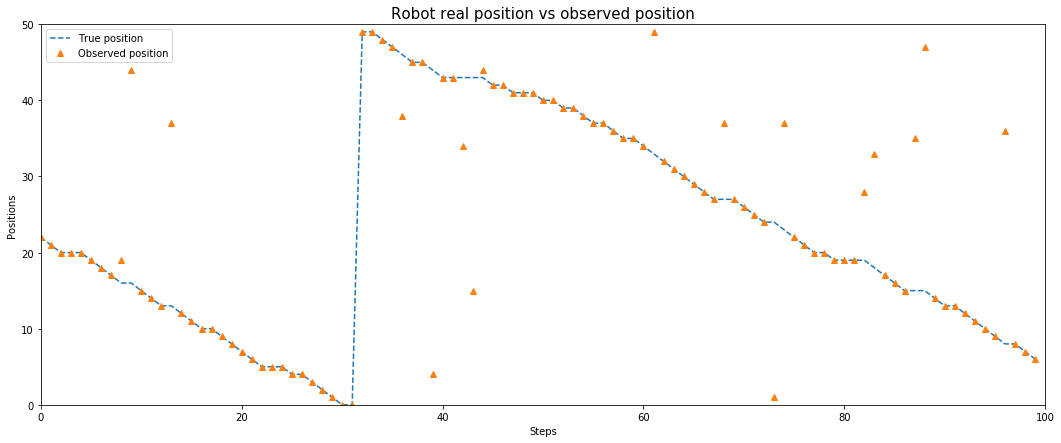

In [7]:
plt.figure(figsize=(18, 7))
plt.xlim(0, K)
plt.ylim(0, N)

plt.plot(X_hist, linestyle='--',label='True position')
plt.plot(Y_hist, '^',label='Observed position')

plt.title("Robot real position vs observed position", fontsize=15)
plt.xlabel("Steps", fontsize=10)
plt.ylabel("Positions", fontsize=10)

plt.legend()
plt.show()

It seems that most of the observed positions - orange triangles - are on the true position line - blue -, meaning that most of the time the robot's sensors managed to match with the true location. The deal is now to compute an algorithm that smooths the errors. 

### Question 5

Implement the Forward-Backward algorithm for computing the quantities defined in 3-a,b,f. (Attention: be careful with numerical stability! Modify the log-sum-exp trick for this algorithm)

In [8]:
def forward_pred(log_prob,trans_mat):
    log_prob_max = np.max(log_prob)
    log_pred = log_prob_max + np.log(np.dot(trans_mat, np.exp(log_prob - log_prob_max))) #numeric trick
    return log_pred

def update(obs, log_prob,obs_mat):
    log_update = np.log(obs_mat)[obs,:] + log_prob
    return log_update

def backward_pred(log_prob,trans_mat):
    log_prob_max = np.max(log_prob)
    log_post = log_prob_max + np.log(np.dot(np.transpose(trans_mat),np.exp(log_prob - log_prob_max))) #numeric trick
    return log_post

def normalize(A, axis=None):
    Z = np.sum(A, axis=axis,keepdims=True)
    idx = np.where(Z == 0)
    Z[idx] = 1
    return A/Z

def normalize_exp(log_prob, axis=None):
    tmp = np.max(log_prob, keepdims=True, axis=axis)
    prob = normalize(np.exp(log_prob - tmp), axis=axis)
    return prob


In [9]:
def forward_alg(X_hist,Y_hist,trans_mat,obs_mat):
    log_alpha = np.zeros((N, K))
    log_alpha_pred = np.zeros((N, K))

    for k in range(K):
        if k == 0:
            log_alpha_pred[:, 0] = np.log(p_x1)
        else:
            log_alpha_pred[:,k] = forward_pred(log_alpha[:,k-1],trans_mat) #alpha prediction
        log_alpha[:,k] = update(Y_hist[k],log_alpha_pred[:,k],obs_mat)  #alpha update
    return log_alpha,log_alpha_pred

log_alpha,log_alpha_pred = forward_alg(X_hist,Y_hist,trans_mat,obs_mat)

In [10]:
def backward_alg(X_hist,Y_hist,trans_mat,obs_mat):
    log_beta  = np.zeros((N, K))
    log_beta_pred = np.zeros((N, K))

    for k in range(K-1, -1, -1):
        if k == K-1:
            log_beta_pred[:,k] = np.zeros(N)
        else:
            log_beta_pred[:,k] = backward_pred(log_beta[:,k+1],trans_mat)
        log_beta[:,k] = update(Y_hist[k], log_beta_pred[:,k],obs_mat)
    return log_beta,log_beta_pred

log_beta,log_beta_pred= backward_alg(X_hist,Y_hist,trans_mat,obs_mat)

In [11]:
log_gamma = log_alpha + log_beta_pred

In [12]:
# Normalization due to the log trick
alpha = normalize_exp(log_alpha, axis=0)
alpha_pred = normalize_exp(log_alpha_pred, axis=0)
beta = normalize_exp(log_beta, axis=0)
gamma = normalize_exp(log_gamma, axis=0)

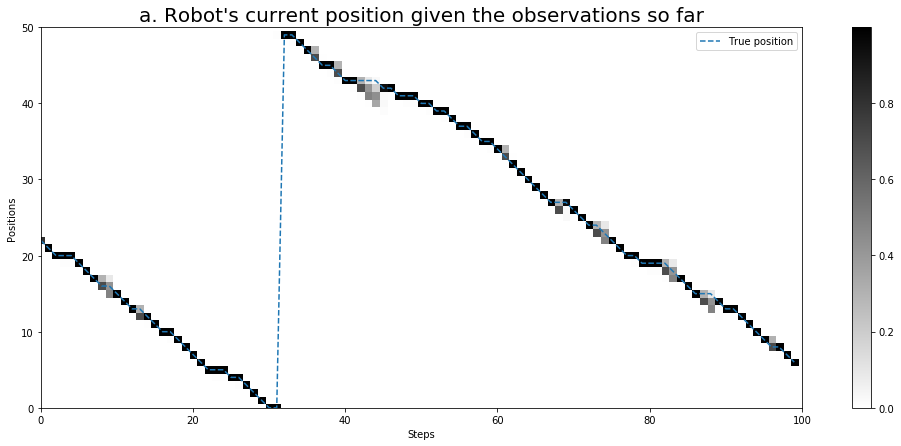

In [26]:
plt.figure(figsize=(18, 7))
plt.xlim(0, K)
plt.ylim(0, N)

plt.plot(X_hist, '--', label="True position")
plt.imshow(alpha, origin="lower",  cmap="binary", label='Strength of probabilities')

plt.title("a. Robot's current position given the observations so far", fontsize=20)
plt.xlabel("Steps", fontsize=10)
plt.ylabel("Positions", fontsize=10)

plt.colorbar()
plt.legend()
plt.show()

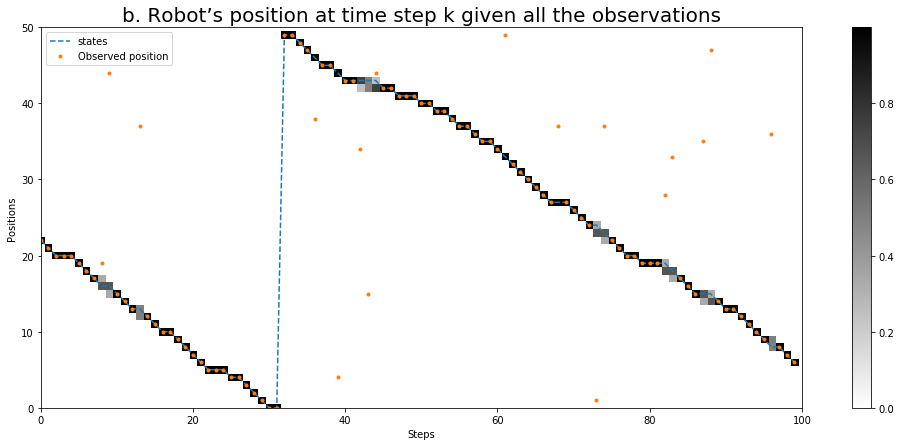

In [14]:
plt.figure(figsize=(18, 7))
plt.xlim(0, K)
plt.ylim(0, N)

plt.plot(X_hist, '--', label="True position")
plt.plot(Y_hist, '.',label='Observed position')
plt.imshow(gamma, origin="lower",  cmap="binary", label='Strength of probabilities')

plt.title("b. Robot’s position at time step k given all the observations", fontsize=20)
plt.xlabel("Steps", fontsize=10)
plt.ylabel("Positions", fontsize=10)

plt.colorbar()
plt.legend()
plt.show()

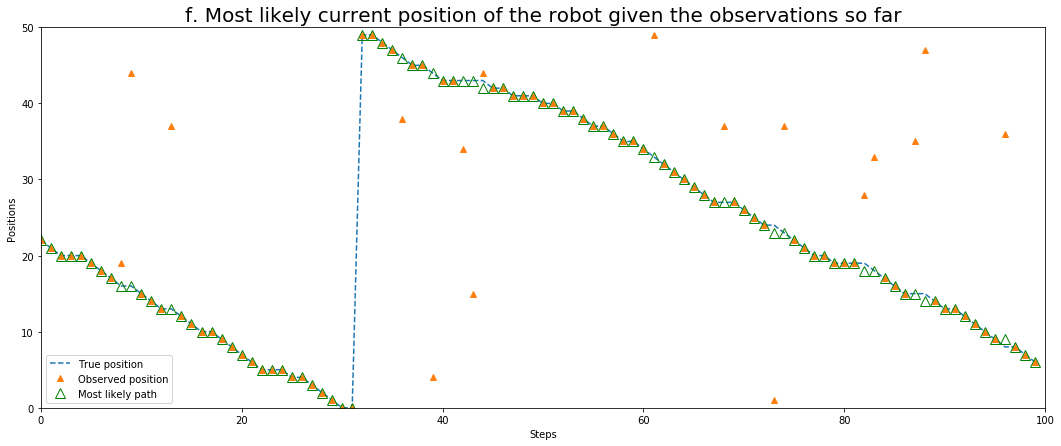

In [15]:
plt.figure(figsize=(18, 7))
plt.xlim(0, K)
plt.ylim(0, N)

plt.plot(X_hist, linestyle='--',label='True position')
plt.plot(Y_hist, '^',label='Observed position')
plt.plot(np.argmax(gamma, axis=0), '^', markersize=10, markerfacecolor="None", markeredgecolor='green', label='Most likely path')

plt.title("f. Most likely current position of the robot given the observations so far", fontsize=20)
plt.xlabel("Steps", fontsize=10)
plt.ylabel("Positions", fontsize=10)

plt.legend()
plt.show()

The graphics with the binary map permits us to see at which probability the algorithm is sure about the robots position.
<br><br>However, in real time processing, we think observing (c) is better: "Distribution of the robot’s next position given the observations so far,".
This will permit to detect errors in real time and (perhaps adjust in real time the sensors or smooth in real time Y).
<br><br>In the graph below, we can see that the algorithm "hesitates" more than the other graphs. One issue that can happen is at the start of the robot as it doesn't have many data to compare with. It can be acceptable depending on the wanted accuracy.

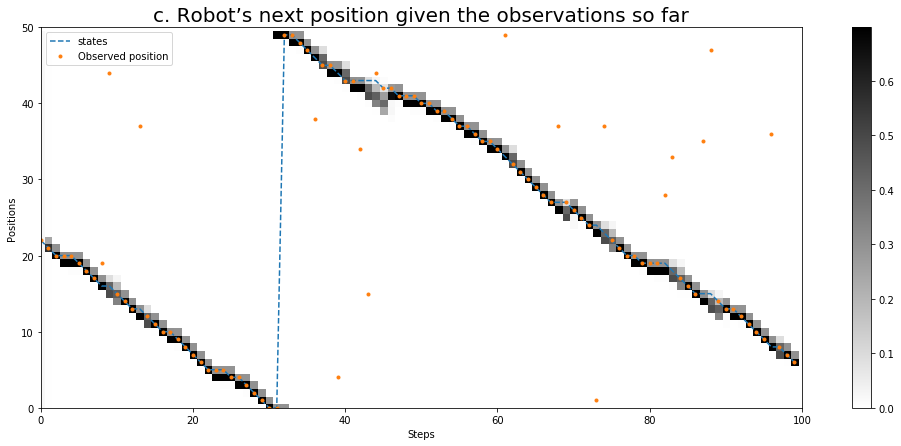

In [16]:
plt.figure(figsize=(18, 7))
plt.xlim(0, K)
plt.ylim(0, N)

plt.plot(X_hist, '--', label="True position")
plt.plot(Y_hist, '.',label='Observed position')
plt.imshow(alpha_pred, origin="lower",  cmap="binary", label='Strength of probabilities')

plt.title("c. Robot’s next position given the observations so far", fontsize=20)
plt.xlabel("Steps", fontsize=10)
plt.ylabel("Positions", fontsize=10)

plt.colorbar()
plt.legend()
plt.show()

### Question 6

Assume now that at each step the robot can be kidnapped with probability κ. If the robot is kidnapped its new position is independent from its previous position and is uniformly distributed. Repeat 4 and 5 for this new model with κ = 0.1. Can you reuse your code?

In [17]:
#Change in the transition matrix should be enough
kidnap = 0.1
trans_mat_kidnap = (1 - kidnap) * trans_mat + kidnap * np.ones((N,N)) / N

In [18]:
X_hist_kidnap,Y_hist_kidnap=scenario_1(trans_mat_kidnap,obs_mat)

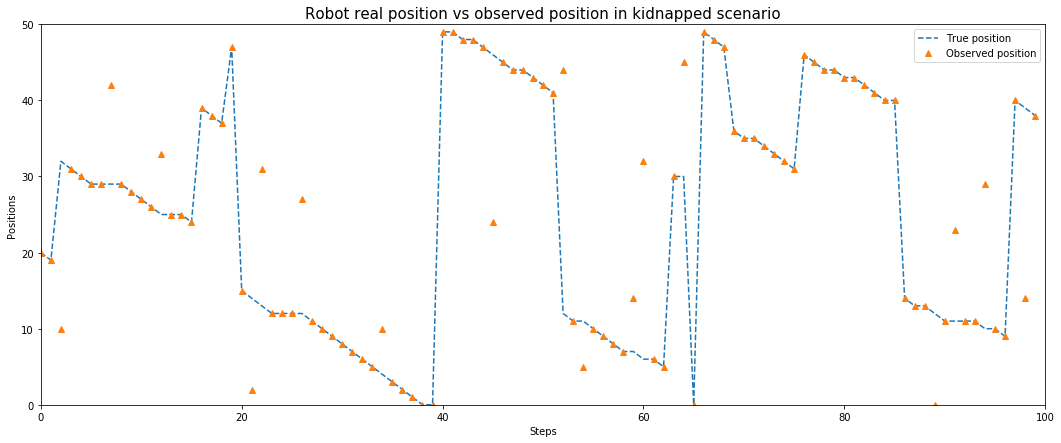

In [19]:
plt.figure(figsize=(18, 7))
plt.xlim(0, K)
plt.ylim(0, N)

plt.plot(X_hist_kidnap, linestyle='--',label='True position')
plt.plot(Y_hist_kidnap, '^',label='Observed position')

plt.title("Robot real position vs observed position in kidnapped scenario", fontsize=15)
plt.xlabel("Steps", fontsize=10)
plt.ylabel("Positions", fontsize=10)

plt.legend()
plt.show()

In [20]:
#Apply forward backward algorithm
log_alpha_kidnap,log_alpha_pred_kidnap = forward_alg(X_hist_kidnap,Y_hist_kidnap,trans_mat_kidnap,obs_mat)
log_beta_kidnap,log_beta_pred_kidnap= backward_alg(X_hist_kidnap,Y_hist_kidnap,trans_mat_kidnap,obs_mat)
log_gamma_kidnap = log_alpha_kidnap + log_beta_pred_kidnap

In [21]:
#Normalization step
alpha_kidnap = normalize_exp(log_alpha_kidnap, axis=0)
alpha_pred_kidnap = normalize_exp(log_alpha_pred_kidnap, axis=0)
beta_kidnap = normalize_exp(log_beta_kidnap, axis=0)
gamma_kidnap = normalize_exp(log_gamma_kidnap, axis=0)

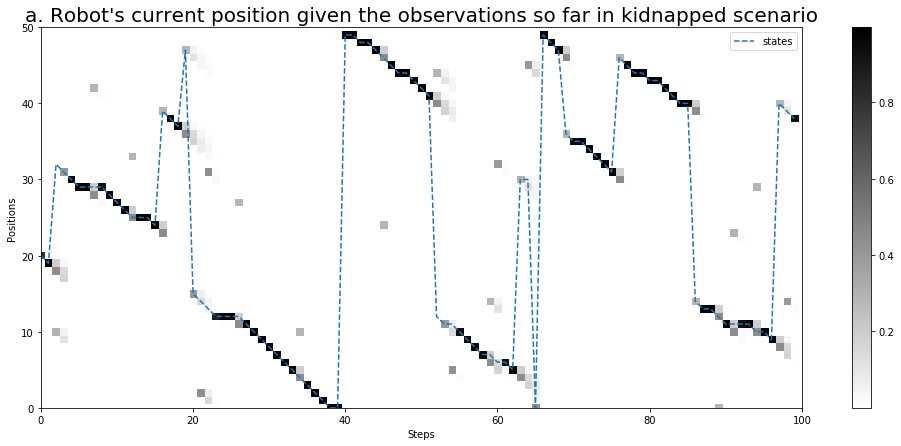

In [22]:
plt.figure(figsize=(18, 7))
plt.xlim(0, K)
plt.ylim(0, N)

plt.plot(X_hist_kidnap, '--', label="True position")
plt.imshow(alpha_kidnap, origin="lower",  cmap="binary", label='Strength of probabilities')

plt.title("a. Robot's current position given the observations so far in kidnapped scenario", fontsize=20)
plt.xlabel("Steps", fontsize=10)
plt.ylabel("Positions", fontsize=10)

plt.colorbar()
plt.legend()
plt.show()

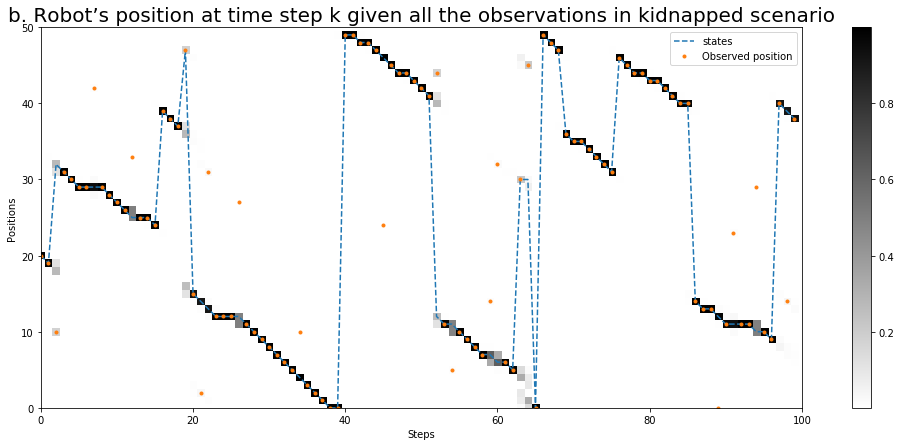

In [23]:
plt.figure(figsize=(18, 7))
plt.xlim(0, K)
plt.ylim(0, N)

plt.plot(X_hist_kidnap, '--', label="True position")
plt.plot(Y_hist_kidnap, '.',label='Observed position')
plt.imshow(gamma_kidnap, origin="lower",  cmap="binary", label='Strength of probabilities')

plt.title("b. Robot’s position at time step k given all the observations in kidnapped scenario", fontsize=20)
plt.xlabel("Steps", fontsize=10)
plt.ylabel("Positions", fontsize=10)

plt.colorbar()
plt.legend()
plt.show()

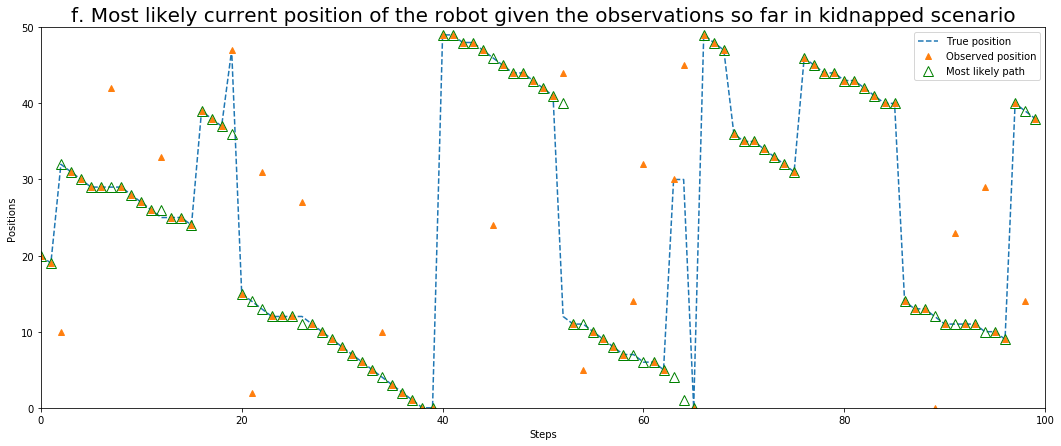

In [24]:
plt.figure(figsize=(18, 7))
plt.xlim(0, K)
plt.ylim(0, N)

plt.plot(X_hist_kidnap, linestyle='--',label='True position')
plt.plot(Y_hist_kidnap, '^',label='Observed position')
plt.plot(np.argmax(gamma_kidnap, axis=0), '^', markersize=10, markerfacecolor="None", markeredgecolor='green', label='Most likely path')

plt.title("f. Most likely current position of the robot given the observations so far in kidnapped scenario", fontsize=20)
plt.xlabel("Steps", fontsize=10)
plt.ylabel("Positions", fontsize=10)

plt.legend()
plt.show()

<br><br>In real time processing, observing (c) is interesting: "Distribution of the robot’s next position given the observations so far,".
This will permit to detect errors in real time and (perhaps adjust in real time the sensors or smooth in real time Y).
<br><br>In the graph below, we can see that the algorithm does not manage well the kidnapping which is normal: it is inferring accoring to past data and cannot get a schem of the kidnapping. However, it is interesting to see that once it has iterated a few steps after a kidnapping, it infers pretty well: as if it only cared about the last few observations. 

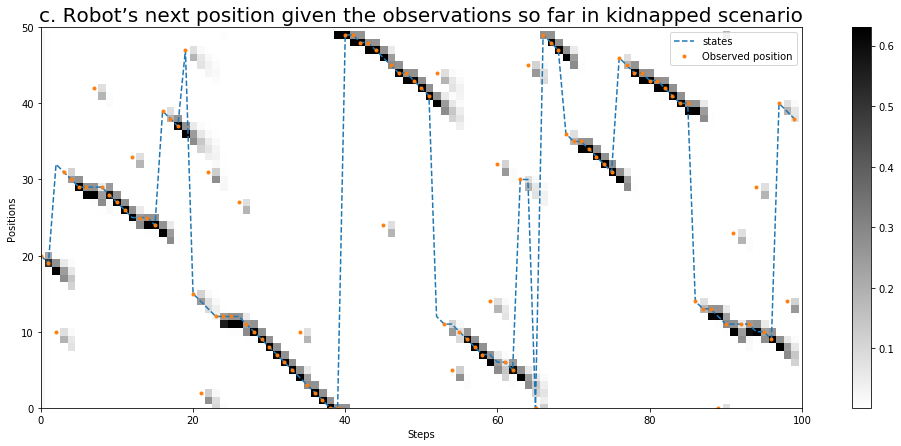

In [25]:
plt.figure(figsize=(18, 7))
plt.xlim(0, K)
plt.ylim(0, N)

plt.plot(X_hist_kidnap, '--', label="True position")
plt.plot(Y_hist_kidnap, '.',label='Observed position')
plt.imshow(alpha_pred_kidnap, origin="lower",  cmap="binary", label='Strength of probabilities')

plt.title("c. Robot’s next position given the observations so far in kidnapped scenario", fontsize=20)
plt.xlabel("Steps", fontsize=10)
plt.ylabel("Positions", fontsize=10)

plt.colorbar()
plt.legend()
plt.show()

An interesting point that should be taken into consideration: this lab was only a 1 dimensional problem. However, even if the robot had more freedom in its moves, it wouldn't have been complicated. We would only have had to change the transition and observation matrix. One may ask himself how to find the probabilities: by using historical data provided during the testing of the robot.